### Import necessary modules

In [1]:
# For data processing
import numpy as np
import pandas as pd

# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For Model
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

# For progress bar
from tqdm import tqdm

# For handling json files
import json

### Model training

In [2]:
# To store training histories of different resampling methods
training_histories = {}
tests_performance = {'Test Accuracy': [], 'Test Precision': [], 'Test Recall': [], 'Test F1 Score': []}

### 1. First Model (Original)

#### Data preparation

In [3]:
# Import and prepare dataset
train_stroke_data = pd.read_csv('train.csv', index_col=0)
train_stroke_data = train_stroke_data.drop(columns=['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'])
#train_df = train_df.drop(columns=['decade_released', 'genres', 'revenue'])

test_stroke_data = pd.read_csv('test.csv', index_col=0)
test_stroke_data = test_stroke_data.drop(columns=['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'])

# Split into X and y
X_train, y_train = train_stroke_data.iloc[:, :-1], train_stroke_data.iloc[:, -1]
X_test, y_test = test_stroke_data.iloc[:, :-1], test_stroke_data.iloc[:, -1]

# Standardize inputs
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test) 

#### Create model

In [4]:
def create_model(hidden_layer_units, input_dim, dropout=False, dropout_rate=0.2, model_name='model'):
    """
    Creates a neural network classifier model with:
        - l hidden layers, where l is len(hidden_layer_units)
        - hidden_layer_units[i] units for i'th layer
        - Binary Crossentropy loss
        - Adam optimizer
        - Accuracy, precision, and recall metrics
        - Dropout in each layer (optional)
        - Model name model_name
    
    Returns the compiled model.
    """
    
    model = Sequential(name=model_name)
    
    # Input layer
    model.add(Dense(hidden_layer_units[0], activation='relu', input_dim=input_dim, name='Dense_1'))
    
    if dropout == True:
        model.add(Dropout(dropout_rate, name='Dropout_1'))    
    
    # Add the hidden layers
    l = 2
    for units in hidden_layer_units[1:]:
        model.add(Dense(units, activation='relu', name=f'Dense_{l}'))
        l += 1
        
        if dropout == True:
            model.add(Dropout(dropout_rate, name=f'Dropout_{l}'))
    
    # Output layer (sigmoid outputs [0, 1])
    model.add(Dense(1, activation='sigmoid', name='Output'))
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])
    
    return model

In [5]:
# Create NN model
model = create_model([16, 16, 16], input_dim=len(X_train[0]), model_name='original-model')
model.summary()

Model: "original-model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_1 (Dense)             (None, 16)                96        
                                                                 
 Dense_2 (Dense)             (None, 16)                272       
                                                                 
 Dense_3 (Dense)             (None, 16)                272       
                                                                 
 Output (Dense)              (None, 1)                 17        
                                                                 
Total params: 657
Trainable params: 657
Non-trainable params: 0
_________________________________________________________________


#### Model training

In [ ]:
history = model.fit(X_train, y_train, batch_size=16, epochs=100)

# Save training history
training_histories['Original'] = history

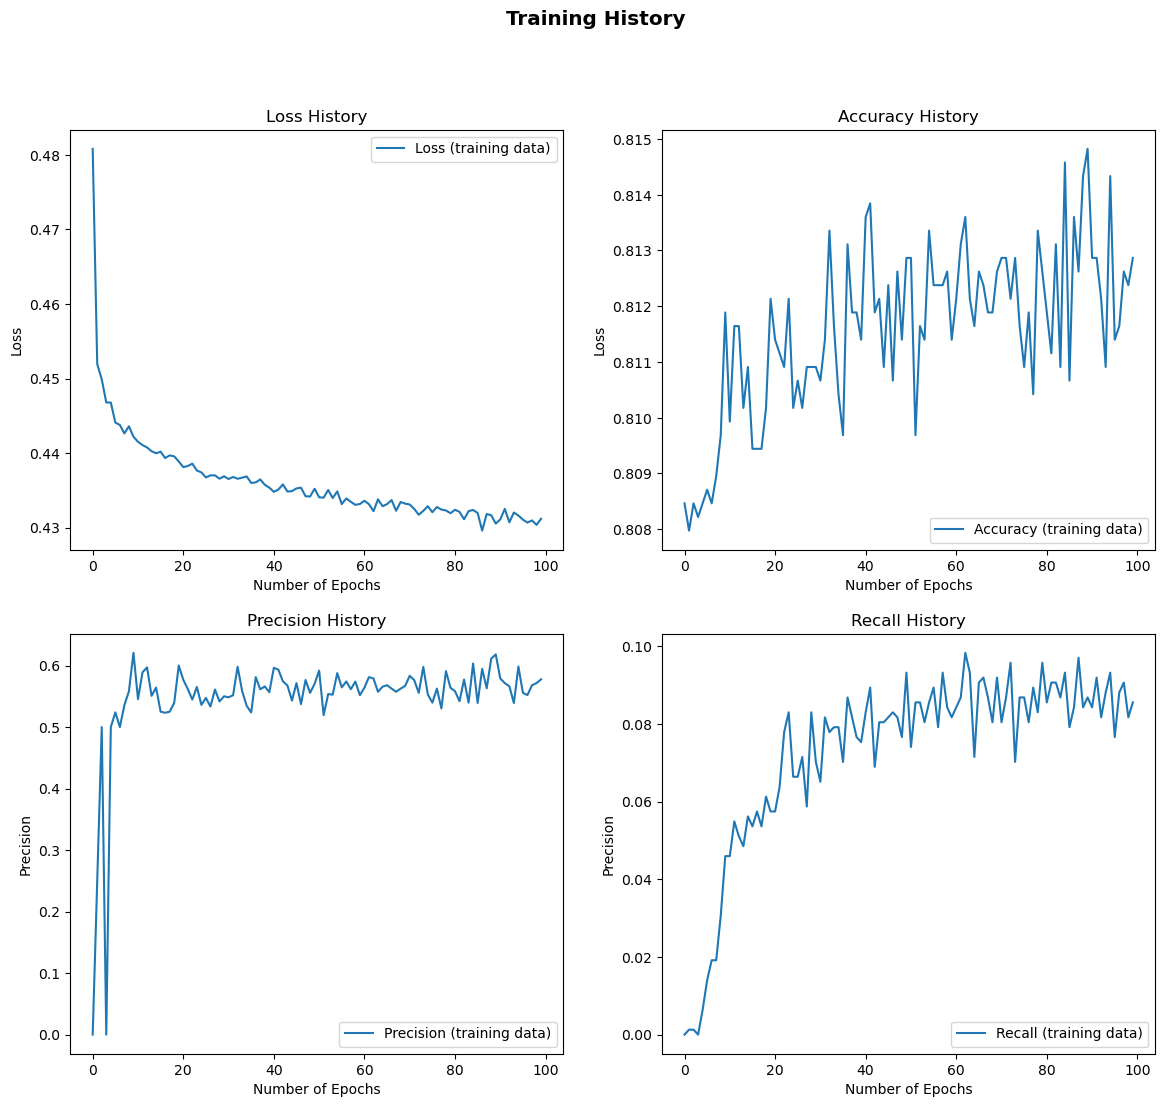

In [7]:
"""
Creates a visualization of model's training process that contains:
    - Loss
    - Accuracy
    - Precision
    - Recall
"""
f, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 12))
f.suptitle('Training History', fontweight='bold', fontsize='x-large')
    
ax[0][0].plot(history.history['loss'], label='Loss (training data)')
ax[0][0].set_title('Loss History')
ax[0][0].set(ylabel='Loss', xlabel='Number of Epochs')
ax[0][0].legend(loc="upper right")

ax[0][1].plot(history.history['accuracy'], label='Accuracy (training data)')
ax[0][1].set_title('Accuracy History')
ax[0][1].set(ylabel='Loss', xlabel='Number of Epochs')
ax[0][1].legend(loc="lower right")    
    
ax[1][0].plot(history.history['precision'], label='Precision (training data)')
ax[1][0].set_title('Precision History')
ax[1][0].set(ylabel='Precision', xlabel='Number of Epochs')
ax[1][0].legend(loc="lower right")
        
ax[1][1].plot(history.history['recall'], label='Recall (training data)')
ax[1][1].set_title('Recall History')
ax[1][1].set(ylabel='Precision', xlabel='Number of Epochs')
ax[1][1].legend(loc="lower right")

#### Model performance on train and test set

In [8]:
def visualize_performance(y_train, y_train_pred, y_test, y_test_pred):
    """
    Creates a confusion matrix visualization for train and test set
    using heatmap with added information such as:
        - Accuracy
        - Precision
        - Recall
        - F1 score
        
    Returns the accuracy, precision, recall, and F1 score from test set.
    """
    
    f, ax = plt.subplots(ncols=2, figsize=(14, 4))
    f.suptitle('Training vs Test Performance', fontweight='bold', fontsize='x-large')
    
    # Training set
    cf_train = confusion_matrix(y_train, y_train_pred)
    sns.heatmap(cf_train, fmt='.0f', annot=True, ax=ax[0])
    
    # Calculate metrics
    accuracy_train = np.trace(cf_train) / float(np.sum(cf_train))
    precision_train = cf_train[1,1] / sum(cf_train[:,1])
    recall_train = cf_train[1,1] / sum(cf_train[1,:])
    f1_score_train = 2 * precision_train * recall_train / (precision_train + recall_train)
    
    stats_text_train = "\n\nAccuracy={:0.2f}\nPrecision={:0.2f}\nRecall={:0.2f}\nF1 Score={:0.2f}".format(accuracy_train, precision_train, recall_train, f1_score_train)
    
    ax[0].set(xlabel='Predicted' + stats_text_train, ylabel='Actual', title='Training Performance')
    
    # Test set
    cf_test = confusion_matrix(y_test, y_test_pred)
    sns.heatmap(cf_test, fmt='.0f', annot=True, ax=ax[1])
    
    # Calculate metrics
    accuracy_test = np.trace(cf_test) / float(np.sum(cf_test))
    precision_test = cf_test[1,1] / sum(cf_test[:,1])
    recall_test = cf_test[1,1] / sum(cf_test[1,:])
    f1_score_test = 2 * precision_test * recall_test / (precision_test + recall_test)
    
    stats_text_test = "\n\nAccuracy={:0.2f}\nPrecision={:0.2f}\nRecall={:0.2f}\nF1 Score={:0.2f}".format(accuracy_test, precision_test, recall_test, f1_score_test)
    
    ax[1].set(xlabel='Predicted' + stats_text_test, ylabel='Actual', title='Test Performance')
    
    plt.show()
    
    return accuracy_test, precision_test, recall_test, f1_score_test
def test_performance(y_test, y_test_pred):
    """ 
    Returns the accuracy, precision, recall, and F1 score from test set.
    """

    # Test set
    cf_test = confusion_matrix(y_test, y_test_pred)
    
    # Calculate metrics
    accuracy_test = np.trace(cf_test) / float(np.sum(cf_test))
    precision_test = cf_test[1,1] / sum(cf_test[:,1])
    recall_test = cf_test[1,1] / sum(cf_test[1,:])
    f1_score_test = 2 * precision_test * recall_test / (precision_test + recall_test)
    
    return accuracy_test, precision_test, recall_test, f1_score_test

32/32 [==============================] - 0s 2ms/step


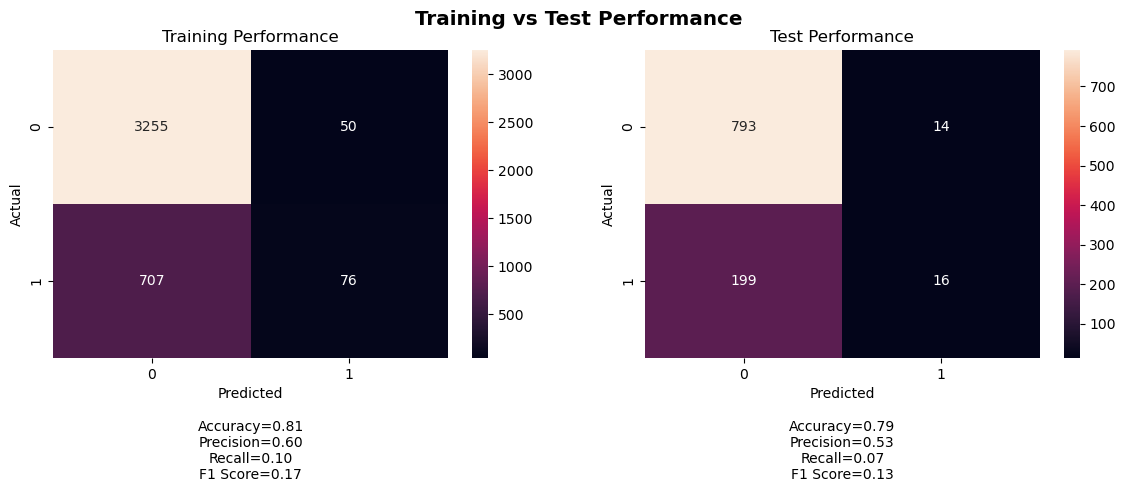

In [9]:
# Change probabilities to 0s and 1s
y_train_pred = (model.predict(X_train) >= 0.5).astype('int64')
y_test_pred = (model.predict(X_test) >= 0.5).astype('int64')


accuracy, precision, recall, f1_score = visualize_performance(y_train, y_train_pred, y_test, y_test_pred)

# Save values
tests_performance['Test Accuracy'].append(('Original', accuracy))
tests_performance['Test Precision'].append(('Original', precision))
tests_performance['Test Recall'].append(('Original', recall))
tests_performance['Test F1 Score' ].append(('Original', f1_score))

This model achieved an accuracy of 0.81 during training and an accuracy of 0.79 during testing. 

The precision was 0.60 during training and 0.53 during testing. 

The recall was quite low at 0.10 during training and 0.07 during testing. 

The F1 score was 0.17 during training and 0.13 during testing. 

Overall, this model performed decently during training but suffered from overfitting during testing.

### 2. Second Model (Oversampling)

This model was developed to address the imbalanced class distribution of the dataset. 

#### Data preparation

In [10]:
# Import and prepare dataset
train_stroke_data = pd.read_csv('oversampled-train.csv', index_col=0)
train_stroke_data = train_stroke_data.drop(columns=['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'])

test_stroke_data = pd.read_csv('test.csv', index_col=0)
test_stroke_data = test_stroke_data.drop(columns=['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'])

# Split into X and y
X_train, y_train = train_stroke_data.iloc[:, :-1], train_stroke_data.iloc[:, -1]
X_test, y_test = test_stroke_data.iloc[:, :-1], test_stroke_data.iloc[:, -1]

# Standardize inputs
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test) 

#### Create model

In [11]:
# Create NN model
model = create_model([16, 16, 16], input_dim=len(X_train[0]), model_name='oversampling-model')
model.summary()

Model: "oversampling-model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_1 (Dense)             (None, 16)                96        
                                                                 
 Dense_2 (Dense)             (None, 16)                272       
                                                                 
 Dense_3 (Dense)             (None, 16)                272       
                                                                 
 Output (Dense)              (None, 1)                 17        
                                                                 
Total params: 657
Trainable params: 657
Non-trainable params: 0
_________________________________________________________________


#### Model training

In [ ]:
# Model training
history = model.fit(X_train, y_train, batch_size=16, epochs=100)
training_histories['Oversampling'] = history

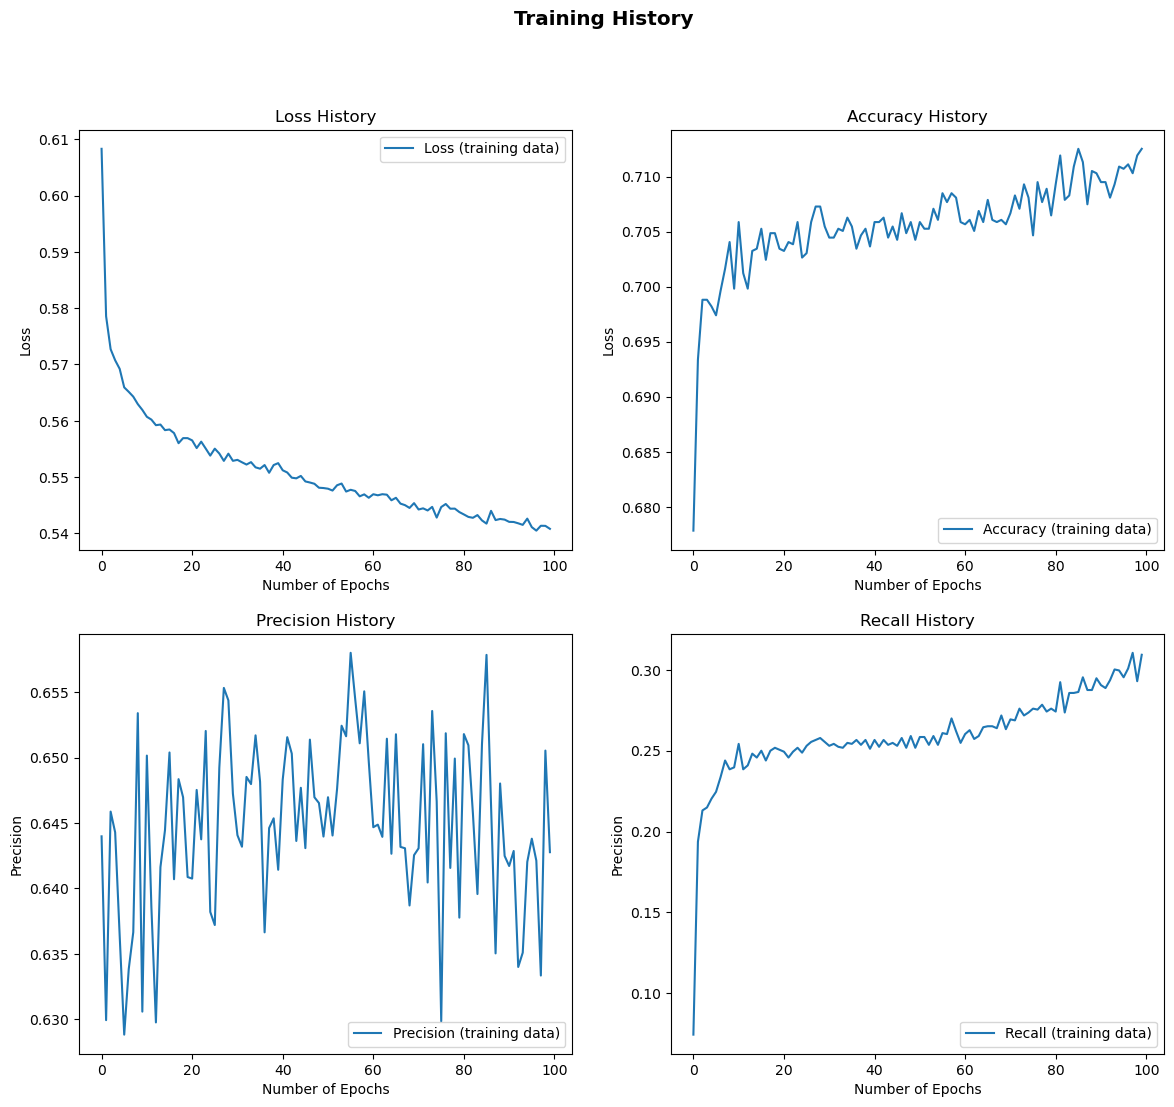

In [13]:
"""
Creates a visualization of model's training process that contains:
    - Loss
    - Accuracy
    - Precision
    - Recall
"""
f, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 12))
f.suptitle('Training History', fontweight='bold', fontsize='x-large')
    
ax[0][0].plot(history.history['loss'], label='Loss (training data)')
ax[0][0].set_title('Loss History')
ax[0][0].set(ylabel='Loss', xlabel='Number of Epochs')
ax[0][0].legend(loc="upper right")

ax[0][1].plot(history.history['accuracy'], label='Accuracy (training data)')
ax[0][1].set_title('Accuracy History')
ax[0][1].set(ylabel='Loss', xlabel='Number of Epochs')
ax[0][1].legend(loc="lower right")    
    
ax[1][0].plot(history.history['precision'], label='Precision (training data)')
ax[1][0].set_title('Precision History')
ax[1][0].set(ylabel='Precision', xlabel='Number of Epochs')
ax[1][0].legend(loc="lower right")
        
ax[1][1].plot(history.history['recall'], label='Recall (training data)')
ax[1][1].set_title('Recall History')
ax[1][1].set(ylabel='Precision', xlabel='Number of Epochs')
ax[1][1].legend(loc="lower right")

#### Model performance on train and test sets

32/32 [==============================] - 0s 2ms/step


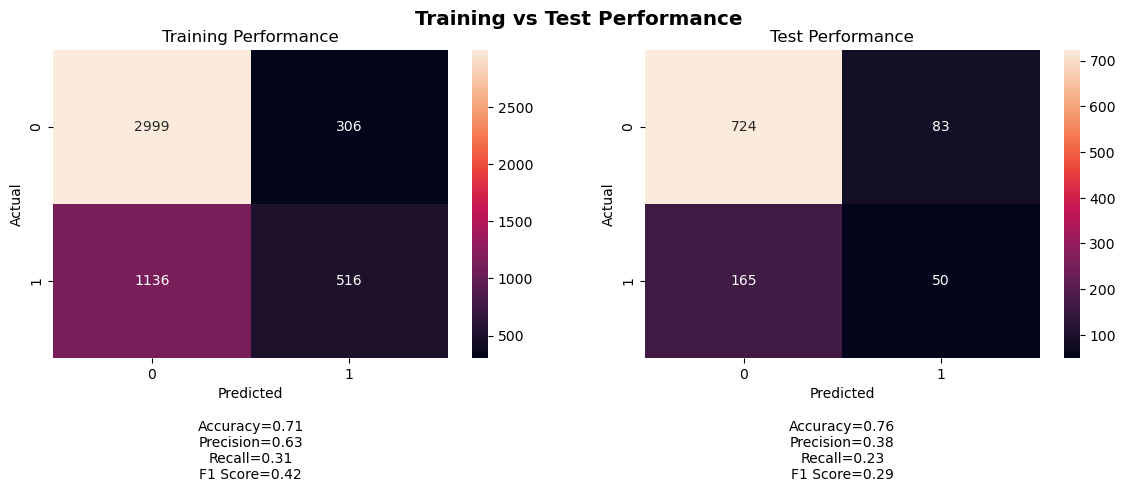

In [14]:
# Change probabilities to 0s and 1s
y_train_pred = (model.predict(X_train) >= 0.5).astype('int64')
y_test_pred = (model.predict(X_test) >= 0.5).astype('int64')

accuracy, precision, recall, f1_score = visualize_performance(y_train, y_train_pred, y_test, y_test_pred)

# Save values
tests_performance['Test Accuracy'].append(('Oversampling', accuracy))
tests_performance['Test Precision'].append(('Oversampling', precision))
tests_performance['Test Recall'].append(('Oversampling', recall))
tests_performance['Test F1 Score' ].append(('Oversampling', f1_score))


The oversampling model achieved an accuracy of 0.71 during training and an accuracy of 0.76 during testing. 

The precision was 0.63 during training and 0.38 during testing. 

The recall was higher at 0.31 during training and 0.23 during testing.

The F1 score improved significantly to 0.42 during training and 0.29 during testing. 

The oversampling model improved the recall and F1 score but decreased precision during testing.

### 3. Third Model (SMOTETomek Resampling)

This model utilized the SMOTETomek resampling technique to address the imbalanced class distribution of the dataset.


#### Data preparation

In [15]:
# Import and prepare dataset
train_stroke_data = pd.read_csv('smotetomek-train.csv', index_col=0)
train_stroke_data = train_stroke_data.drop(columns=['hypertension', 'heart_disease', 'stroke'])

test_stroke_data = pd.read_csv('test.csv', index_col=0)
test_stroke_data = test_stroke_data.drop(columns=['hypertension', 'heart_disease', 'stroke', 'gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'])

# Split into X and y
X_train, y_train = train_stroke_data.iloc[:, :-1], train_stroke_data.iloc[:, -1]
X_test, y_test = test_stroke_data.iloc[:, :-1], test_stroke_data.iloc[:, -1]

# Standardize inputs
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test) 

#### Create model

In [16]:
model = create_model([16, 16, 16], input_dim=len(X_train[0]), model_name='smotetomek-model')
model.summary()

Model: "smotetomek-model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_1 (Dense)             (None, 16)                48        
                                                                 
 Dense_2 (Dense)             (None, 16)                272       
                                                                 
 Dense_3 (Dense)             (None, 16)                272       
                                                                 
 Output (Dense)              (None, 1)                 17        
                                                                 
Total params: 609
Trainable params: 609
Non-trainable params: 0
_________________________________________________________________


#### Model training

In [ ]:
# Model training
history = model.fit(X_train, y_train, batch_size=16, epochs=100)
training_histories['SMOTETomek'] = history

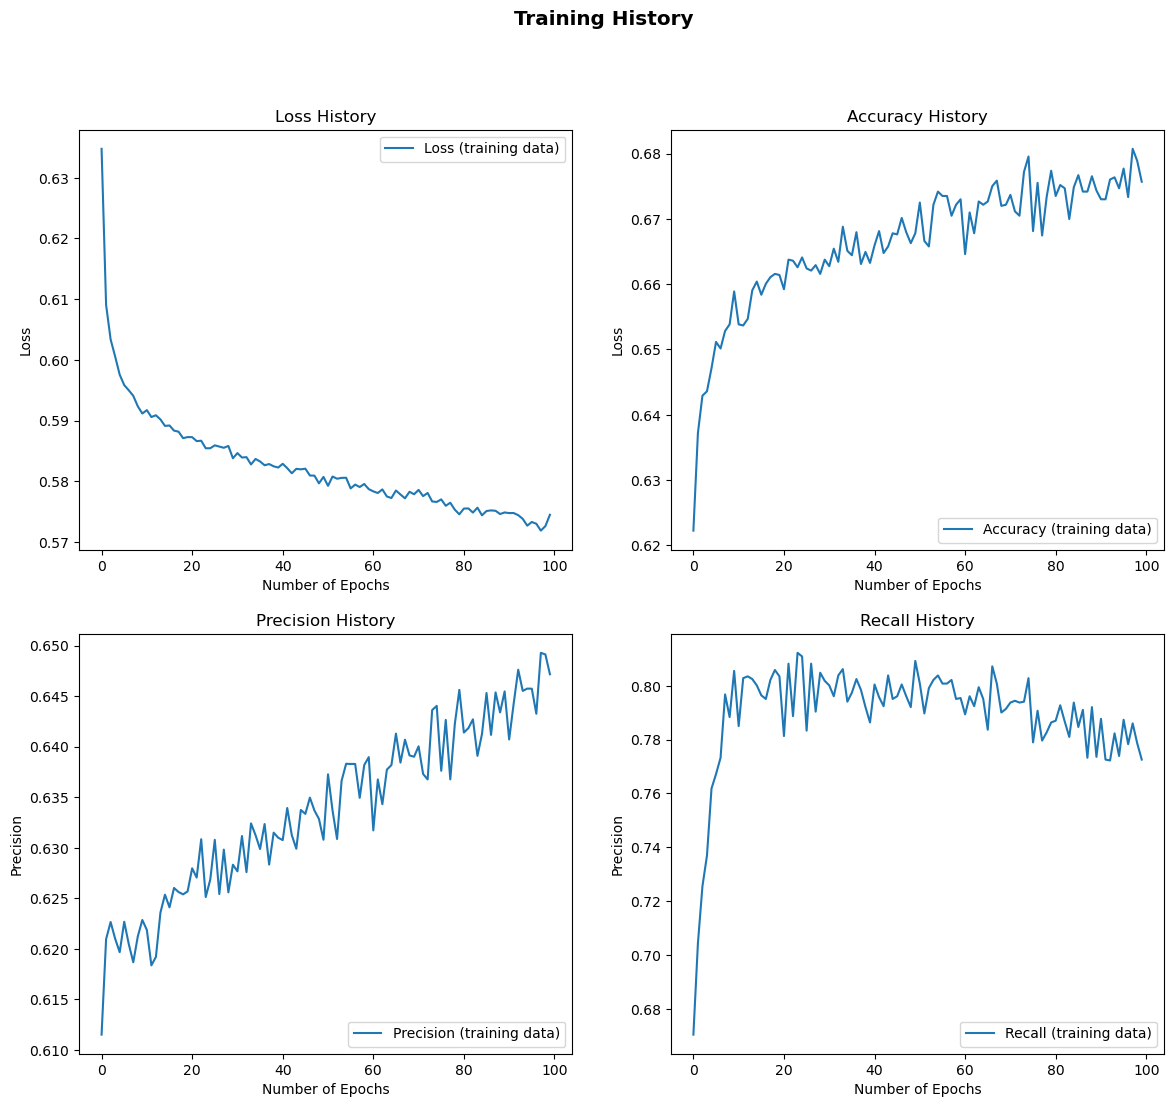

In [18]:
"""
Creates a visualization of model's training process that contains:
    - Loss
    - Accuracy
    - Precision
    - Recall
"""
f, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 12))
f.suptitle('Training History', fontweight='bold', fontsize='x-large')
    
ax[0][0].plot(history.history['loss'], label='Loss (training data)')
ax[0][0].set_title('Loss History')
ax[0][0].set(ylabel='Loss', xlabel='Number of Epochs')
ax[0][0].legend(loc="upper right")

ax[0][1].plot(history.history['accuracy'], label='Accuracy (training data)')
ax[0][1].set_title('Accuracy History')
ax[0][1].set(ylabel='Loss', xlabel='Number of Epochs')
ax[0][1].legend(loc="lower right")    
    
ax[1][0].plot(history.history['precision'], label='Precision (training data)')
ax[1][0].set_title('Precision History')
ax[1][0].set(ylabel='Precision', xlabel='Number of Epochs')
ax[1][0].legend(loc="lower right")
        
ax[1][1].plot(history.history['recall'], label='Recall (training data)')
ax[1][1].set_title('Recall History')
ax[1][1].set(ylabel='Precision', xlabel='Number of Epochs')
ax[1][1].legend(loc="lower right")

#### Model performance on train and test sets

32/32 [==============================] - 0s 1ms/step


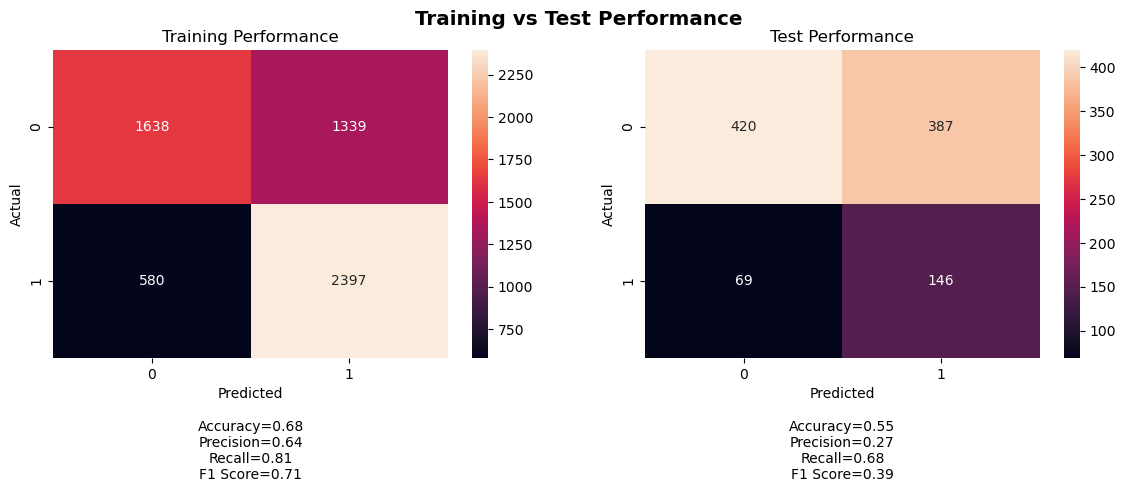

In [19]:
# Change probabilities to 0s and 1s
y_train_pred = (model.predict(X_train) >= 0.5).astype('int64')
y_test_pred = (model.predict(X_test) >= 0.5).astype('int64')

accuracy, precision, recall, f1_score = visualize_performance(y_train, y_train_pred, y_test, y_test_pred)

# Save values
tests_performance['Test Accuracy'].append(('SMOTETomek', accuracy))
tests_performance['Test Precision'].append(('SMOTETomek', precision))
tests_performance['Test Recall'].append(('SMOTETomek', recall))
tests_performance['Test F1 Score' ].append(('SMOTETomek', f1_score))


The SMOTETomek Resampling model achieved an accuracy of 0.68 during training and an accuracy of 0.55 during testing.

The precision was 0.64 during training and 0.27 during testing.

The recall improved significantly to 0.81 during training and 0.68 during testing. 

The F1 score was 0.71 during training and 0.39 during testing.

This model significantly improved the recall but suffered from low precision during testing.

### 4. Fourth Model (SMOTEENN Resampling)

This model utilized the SMOTEENN resampling technique to address the imbalanced class distribution of the dataset.

#### Data preparation

In [20]:
# Import and prepare dataset
train_stroke_data = pd.read_csv('smoteenn-train.csv', index_col=0)
train_stroke_data = train_stroke_data.drop(columns=['hypertension', 'heart_disease', 'stroke'])

test_stroke_data = pd.read_csv('test.csv', index_col=0)
test_stroke_data = test_stroke_data.drop(columns=['hypertension', 'heart_disease', 'stroke', 'gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'])

# Split into X and y
X_train, y_train = train_stroke_data.iloc[:, :-1], train_stroke_data.iloc[:, -1]
X_test, y_test = test_stroke_data.iloc[:, :-1], test_stroke_data.iloc[:, -1]

# Standardize inputs
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test) 

#### Create model

In [21]:
# Create NN model
model = create_model([16, 16, 16], input_dim=len(X_train[0]), model_name='smoteenn-model')
model.summary()

Model: "smoteenn-model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_1 (Dense)             (None, 16)                48        
                                                                 
 Dense_2 (Dense)             (None, 16)                272       
                                                                 
 Dense_3 (Dense)             (None, 16)                272       
                                                                 
 Output (Dense)              (None, 1)                 17        
                                                                 
Total params: 609
Trainable params: 609
Non-trainable params: 0
_________________________________________________________________


#### Model training

In [ ]:
history = model.fit(X_train, y_train, batch_size=16, epochs=100)
training_histories['SMOTEENN'] = history

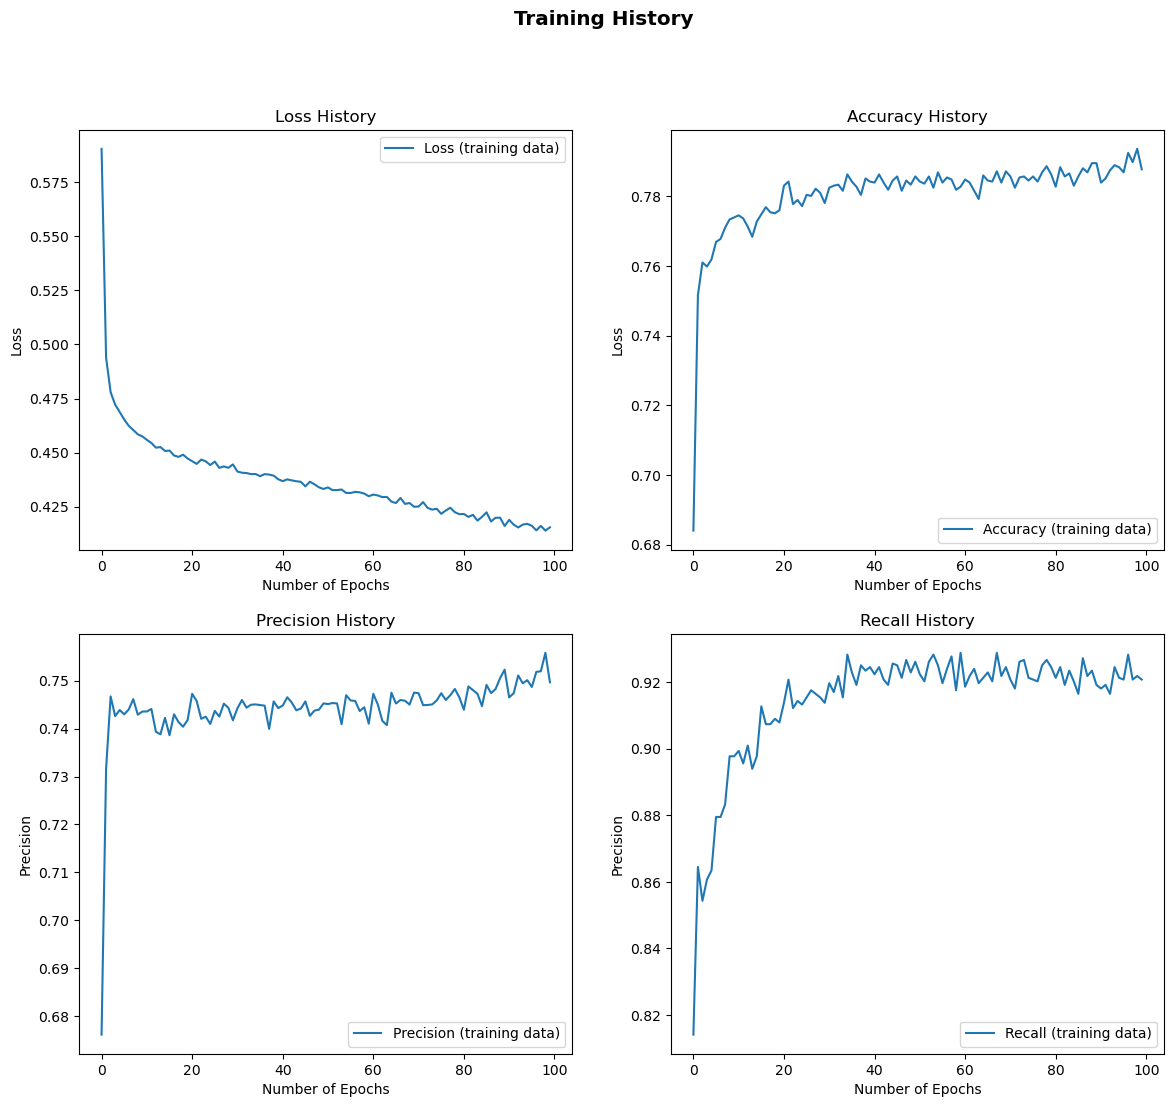

In [23]:
"""
Creates a visualization of model's training process that contains:
    - Loss
    - Accuracy
    - Precision
    - Recall
"""
f, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 12))
f.suptitle('Training History', fontweight='bold', fontsize='x-large')
    
ax[0][0].plot(history.history['loss'], label='Loss (training data)')
ax[0][0].set_title('Loss History')
ax[0][0].set(ylabel='Loss', xlabel='Number of Epochs')
ax[0][0].legend(loc="upper right")

ax[0][1].plot(history.history['accuracy'], label='Accuracy (training data)')
ax[0][1].set_title('Accuracy History')
ax[0][1].set(ylabel='Loss', xlabel='Number of Epochs')
ax[0][1].legend(loc="lower right")    
    
ax[1][0].plot(history.history['precision'], label='Precision (training data)')
ax[1][0].set_title('Precision History')
ax[1][0].set(ylabel='Precision', xlabel='Number of Epochs')
ax[1][0].legend(loc="lower right")
        
ax[1][1].plot(history.history['recall'], label='Recall (training data)')
ax[1][1].set_title('Recall History')
ax[1][1].set(ylabel='Precision', xlabel='Number of Epochs')
ax[1][1].legend(loc="lower right")

#### Model performance on train and test sets

32/32 [==============================] - 0s 2ms/step


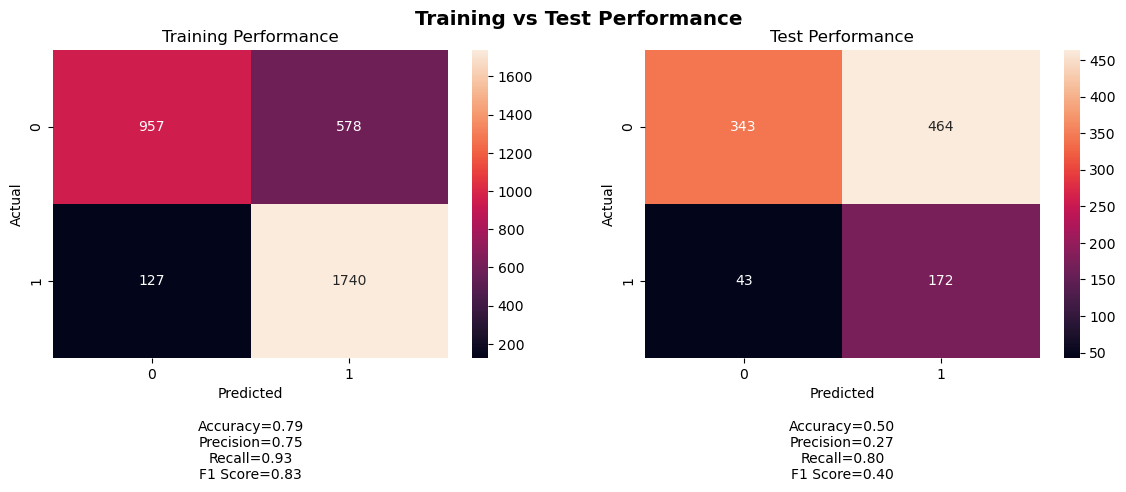

In [24]:
# Change probabilities to 0s and 1s
y_train_pred = (model.predict(X_train) >= 0.5).astype('int64')
y_test_pred = (model.predict(X_test) >= 0.5).astype('int64')

accuracy, precision, recall, f1_score = visualize_performance(y_train, y_train_pred, 
                                                              y_test, y_test_pred)

# Save values
tests_performance['Test Accuracy'].append(('SMOTEENN', accuracy))
tests_performance['Test Precision'].append(('SMOTEENN', precision))
tests_performance['Test Recall'].append(('SMOTEENN', recall))
tests_performance['Test F1 Score' ].append(('SMOTEENN', f1_score))

The SMOTEENN Resampling model achieved an accuracy of 0.78 during training and an accuracy of 0.50 during testing.

The precision was 0.75 during training and 0.27 during testing.

The recall was the highest at 0.93 during training and 0.80 during testing.

The F1 score was 0.83 during training and 0.40 during testing.

The SMOTEENN Resampling model significantly improved the recall but suffered from low precision during testing, similar to the SMOTETomek Resampling model.

### Comparing performance between different resampling methods

#### Performance on test set

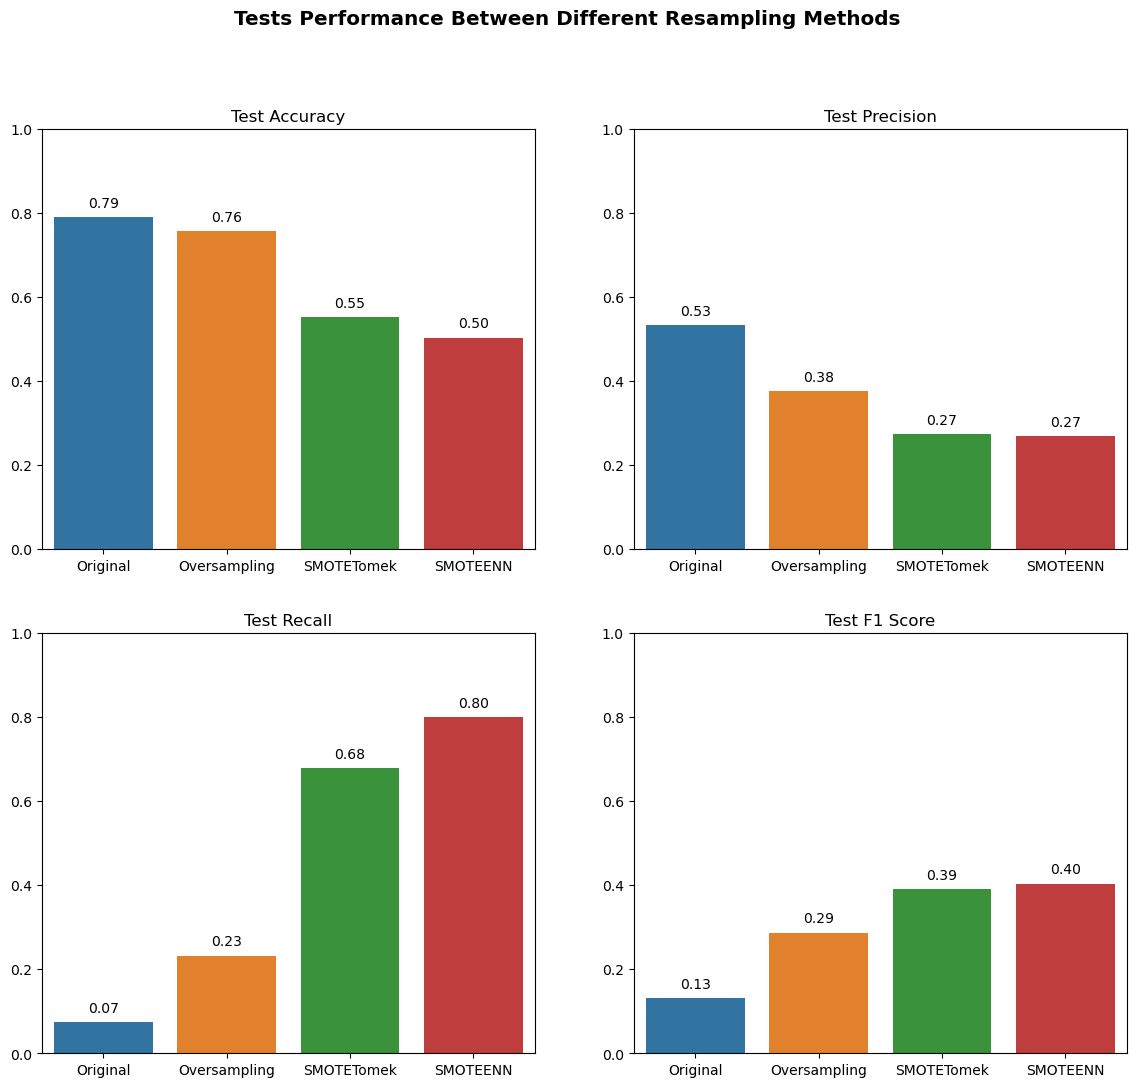

In [25]:
"""
Display 4 barplots comparing:
    - Accuracy
    - Precision
    - Recall
    - F1 Score
on test sets between different resampling methods.
"""
    
f, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 12))
f.suptitle('Tests Performance Between Different Resampling Methods', fontweight='bold', fontsize='x-large')
    
i = 0
for metric, ls in tests_performance.items():
    # Takes the labels
    x = pd.DataFrame(ls).T.iloc[0].to_list()
    # Takes the values
    y = pd.DataFrame(ls).T.iloc[1].to_list()
        
    plot = sns.barplot(x=x, y=y, ax=ax[i // 2][i % 2])
        
    # Show the actual numbers on the barplots
    for p in plot.patches:
        plot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
        
    ax[i // 2][i % 2].set(title=metric)
    ax[i // 2][i % 2].set_ylim(0, 1)
        
    i += 1
    
plt.show()

#### Training histories

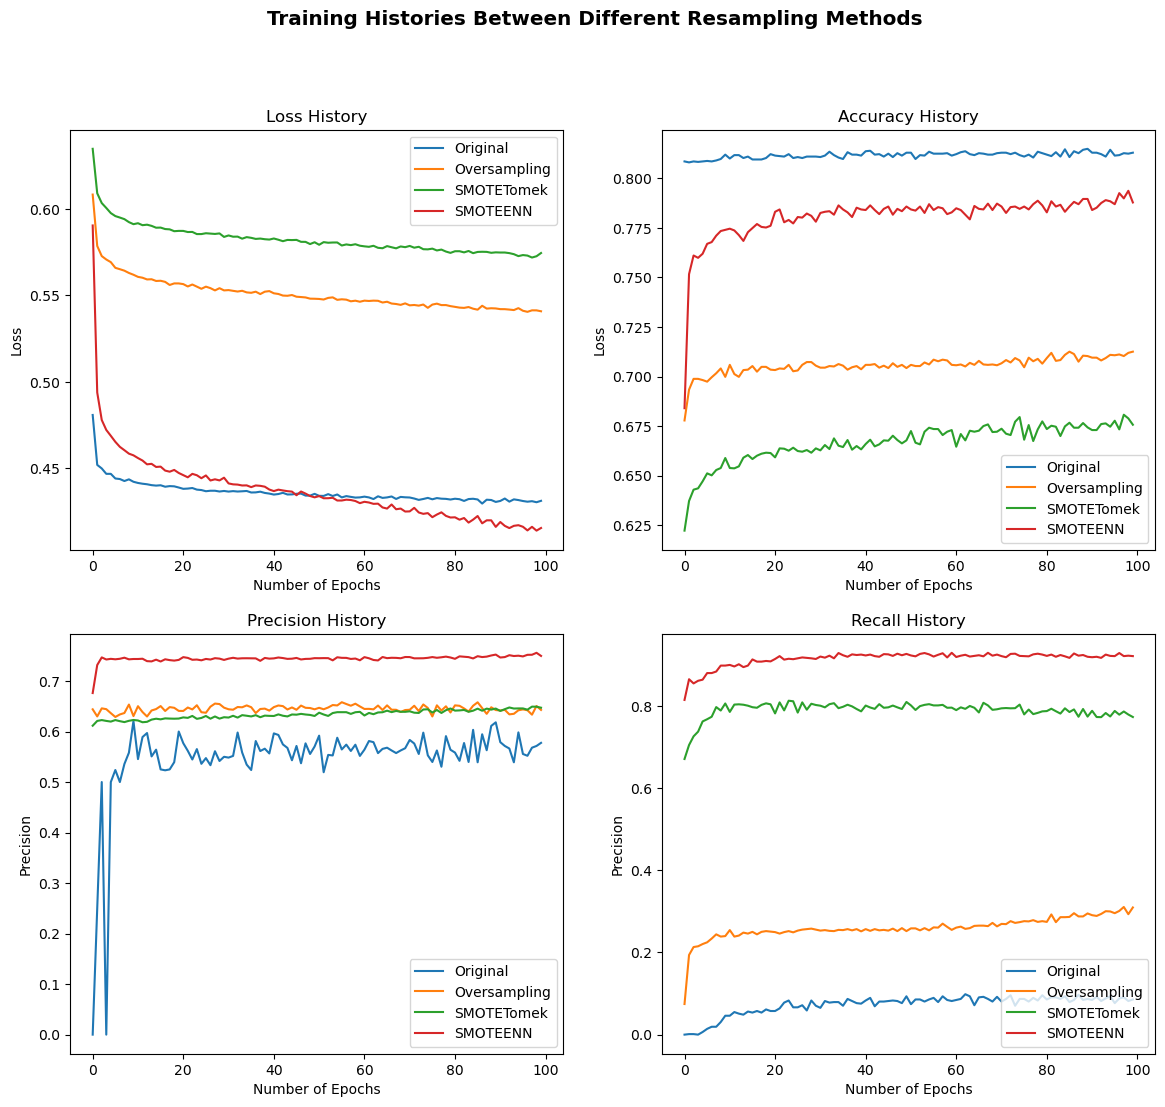

In [26]:
"""
Creates a visualization of training histories from different resampling methods.
    
Input: dictionary (key -> metric, value -> history callback)
"""
f, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 12))
f.suptitle('Training Histories Between Different Resampling Methods'
               , fontweight='bold', fontsize='x-large')
    
# Set title and labels for each axis
ax[0][0].set_title('Loss History')
ax[0][0].set(ylabel='Loss', xlabel='Number of Epochs')

ax[1][0].set_title('Precision History')
ax[1][0].set(ylabel='Precision', xlabel='Number of Epochs')

ax[0][1].set_title('Accuracy History')
ax[0][1].set(ylabel='Loss', xlabel='Number of Epochs')

ax[1][1].set_title('Recall History')
ax[1][1].set(ylabel='Precision', xlabel='Number of Epochs')
    
# Plotting data
for metric, cb in training_histories.items():
    ax[0][0].plot(cb.history['loss'], label=metric)
    ax[0][0].legend(loc="upper right")
        
    ax[0][1].plot(cb.history['accuracy'], label=metric)
    ax[0][1].legend(loc="lower right")
        
    ax[1][0].plot(cb.history['precision'], label=metric)
    ax[1][0].legend(loc="lower right")
        
    ax[1][1].plot(cb.history['recall'], label=metric)
    ax[1][1].legend(loc="lower right")
        
plt.show()

Based on the results above, we can see that all four models were quite successful in addressing the imbalanced class distribution of the dataset, resulting in improved recall scores.

However, the SMOTEENN Resampling model performed the best in terms of recall, achieving a score of 0.93 during training and 0.80 during testing.

The SMOTEENN Resampling model also achieved the highest precision score during training, but suffered from low precision during testing.

It's worth noting that the original model performed reasonably well during training, but overfit during testing.

### Comparing performance on test set multiple times

Since training neural networks are stochastic by design (different training, different results), we should not conclude the effectiveness of a resampling method by just doing a single test.

In [29]:
def repeat_train_and_test(iterations=100):
    
    template = {'Original': 0, 'Oversampling': 0, 'SMOTETomek': 0, 'SMOTEENN': 0}
    # To count the winners for each metric in all iterations
    winner_count = {'Test Accuracy': template.copy(), 
                    'Test Precision': template.copy(), 
                    'Test Recall': template.copy(), 
                    'Test F1 Score': template.copy()}
    
    for i in tqdm(range(iterations)):
        # To store the values of each metric in a single iteration
        tests_performance = {'Test Accuracy': [], 
                             'Test Precision': [], 
                             'Test Recall': [], 
                             'Test F1 Score': []}

        ## 1. First Model (Original)

        # Import and prepare dataset
        train_stroke_data = pd.read_csv('train.csv', index_col=0)
        train_stroke_data = train_stroke_data.drop(columns=['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'])

        test_stroke_data = pd.read_csv('test.csv', index_col=0)
        test_stroke_data = test_stroke_data.drop(columns=['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'])

        # Split into X and y
        X_train, y_train = train_stroke_data.iloc[:, :-1], train_stroke_data.iloc[:, -1]
        X_test, y_test = test_stroke_data.iloc[:, :-1], test_stroke_data.iloc[:, -1]

        # Standardize inputs
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test) 

        # Create NN model
        model = create_model([16, 16, 16], input_dim=len(X_train[0]), model_name='original-model')

        # Model training
        history = model.fit(X_train, y_train, batch_size=16, epochs=100, verbose=0)
        training_histories['Original'] = history

        # Model performance on train and test set
        y_train_pred = (model.predict(X_train) >= 0.5).astype('int64')
        y_test_pred = (model.predict(X_test) >= 0.5).astype('int64')

        accuracy, precision, recall, f1_score = test_performance(y_test, y_test_pred)

        tests_performance['Test Accuracy'].append(('Original', accuracy))
        tests_performance['Test Precision'].append(('Original', precision))
        tests_performance['Test Recall'].append(('Original', recall))
        tests_performance['Test F1 Score' ].append(('Original', f1_score))

        
        ## 2. Second Model (Oversampling)

        # Import and prepare dataset
        train_stroke_data = pd.read_csv('oversampled-train.csv', index_col=0)
        train_stroke_data = train_stroke_data.drop(columns=['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'])

        test_stroke_data = pd.read_csv('test.csv', index_col=0)
        test_stroke_data = test_stroke_data.drop(columns=['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'])

        # Split into X and y
        X_train, y_train = train_stroke_data.iloc[:, :-1], train_stroke_data.iloc[:, -1]
        X_test, y_test = test_stroke_data.iloc[:, :-1], test_stroke_data.iloc[:, -1]

        # Standardize inputs
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test) 

        # Create NN model
        model = create_model([16, 16, 16], input_dim=len(X_train[0]), model_name='oversampling-model')

        # Model training
        history = model.fit(X_train, y_train, batch_size=16, epochs=100, verbose=0)
        training_histories['Oversampling'] = history

        # Model performance on train and test sets
        y_train_pred = (model.predict(X_train) >= 0.5).astype('int64')
        y_test_pred = (model.predict(X_test) >= 0.5).astype('int64')

        accuracy, precision, recall, f1_score = test_performance(y_test, y_test_pred)

        tests_performance['Test Accuracy'].append(('Oversampling', accuracy))
        tests_performance['Test Precision'].append(('Oversampling', precision))
        tests_performance['Test Recall'].append(('Oversampling', recall))
        tests_performance['Test F1 Score' ].append(('Oversampling', f1_score))

        ## 3. Third Model (SMOTETomek Resampling)

        # Import and prepare dataset
        train_stroke_data = pd.read_csv('smotetomek-train.csv', index_col=0)
        train_stroke_data = train_stroke_data.drop(columns=['hypertension', 'heart_disease', 'stroke'])

        test_stroke_data = pd.read_csv('test.csv', index_col=0)
        test_stroke_data = test_stroke_data.drop(columns=['hypertension', 'heart_disease', 'stroke', 'gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'])

        # Split into X and y
        X_train, y_train = train_stroke_data.iloc[:, :-1], train_stroke_data.iloc[:, -1]
        X_test, y_test = test_stroke_data.iloc[:, :-1], test_stroke_data.iloc[:, -1]

        # Standardize inputs
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test) 

        # Create NN model
        model = create_model([16, 16, 16], input_dim=len(X_train[0]), model_name='smotetomek-model')

        # Model training
        history = model.fit(X_train, y_train, batch_size=16, epochs=100, verbose=0)
        training_histories['SMOTETomek'] = history


        # Model performance on train and test set
        y_train_pred = (model.predict(X_train) >= 0.5).astype('int64')
        y_test_pred = (model.predict(X_test) >= 0.5).astype('int64')

        accuracy, precision, recall, f1_score = test_performance(y_test, y_test_pred)
        
        tests_performance['Test Accuracy'].append(('SMOTETomek', accuracy))
        tests_performance['Test Precision'].append(('SMOTETomek', precision))
        tests_performance['Test Recall'].append(('SMOTETomek', recall))
        tests_performance['Test F1 Score' ].append(('SMOTETomek', f1_score))

        ## 4. Fourth Model (SMOTEENN Resampling)

        # Import and prepare dataset
        train_stroke_data = pd.read_csv('smoteenn-train.csv', index_col=0)
        train_stroke_data = train_stroke_data.drop(columns=['hypertension', 'heart_disease', 'stroke'])

        test_stroke_data = pd.read_csv('test.csv', index_col=0)
        test_stroke_data = test_stroke_data.drop(columns=['hypertension', 'heart_disease', 'stroke', 'gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'])

        # Split into X and y
        X_train, y_train = train_stroke_data.iloc[:, :-1], train_stroke_data.iloc[:, -1]
        X_test, y_test = test_stroke_data.iloc[:, :-1], test_stroke_data.iloc[:, -1]

        # Standardize inputs
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test) 

        # Create NN model
        model = create_model([16, 16, 16], input_dim=len(X_train[0]),
                             model_name='smoteenn-model')

        # Model training
        history = model.fit(X_train, y_train, batch_size=16, epochs=100, verbose=0)
        training_histories['SMOTEENN'] = history

        # Model performance on train and test set
        y_train_pred = (model.predict(X_train) >= 0.5).astype('int64')
        y_test_pred = (model.predict(X_test) >= 0.5).astype('int64')

        accuracy, precision, recall, f1_score = test_performance(y_test, y_test_pred)

        tests_performance['Test Accuracy'].append(('SMOTEENN', accuracy))
        tests_performance['Test Precision'].append(('SMOTEENN', precision))
        tests_performance['Test Recall'].append(('SMOTEENN', recall))
        tests_performance['Test F1 Score' ].append(('SMOTEENN', f1_score))
        
        # Find the winners for all metrics
        for metric, ls in tests_performance.items():
            # Get the resampling method name that has the maximum value
            winner_name = max(map(lambda x: x[::-1], ls))[1]
            winner_count[metric][winner_name] += 1
            
    return winner_count

In [ ]:
# Redo the process multiple times and count the winners
winner_count = repeat_train_and_test(iterations=100)

# Save the result into a json file
with open('winner-data.json', 'w') as f:
    json.dump(winner_count, f)

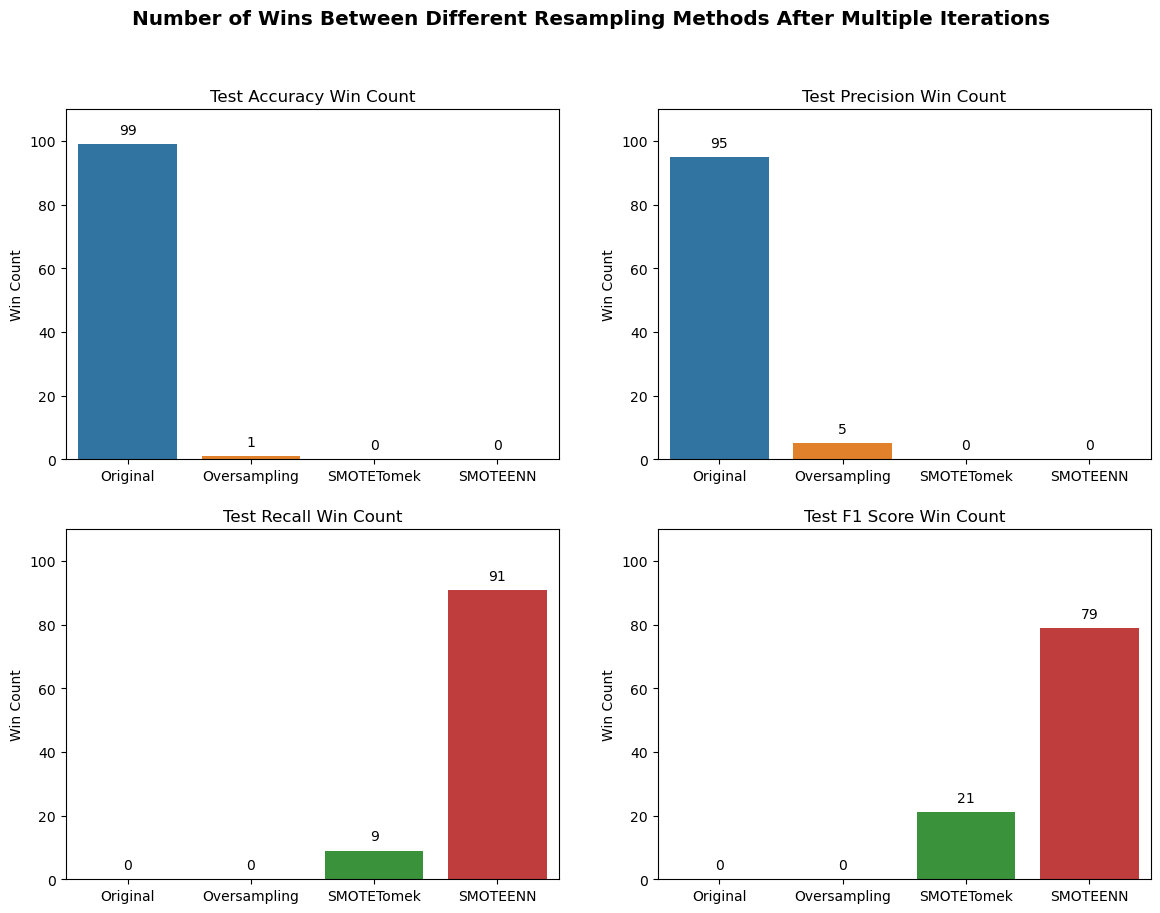

In [31]:
# Load json file
with open('winner-data.json') as f:
    winner_count = json.load(f)
    
"""
Displays 4 barplots containing how many times does each resampling method did the best compared to other methods after multiple iterations for each metric.
"""

f, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
f.suptitle('Number of Wins Between Different Resampling Methods After Multiple Iterations', fontweight='bold', fontsize='x-large')

i = 0
for metric, count in winner_count.items():
    # Takes the labels
    x = list(count.keys())
    # Takes the values
    y = list(count.values())

    plot = sns.barplot(x=x, y=y, ax=ax[i // 2][i % 2])
    for p in plot.patches:
        plot.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

    ax[i // 2][i % 2].set(title=f'{metric} Win Count', ylabel='Win Count')
    ax[i // 2][i % 2].set_ylim(0, 110)

    i += 1

plt.show()

Overall, the SMOTEENN Resampling model is the best option as recall is the most important metric.